In [1]:
# !pip install xgboost
# !pip install -U imbalanced-learn
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

In [2]:
## ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
application_record = pd.read_csv('../static/application_record.csv')
credit_record = pd.read_csv('../static/credit_record.csv')

## Data Labelling and Data Cleaning

We need to label the data that is deemed to be defaulters and data that are not defaulters. The criteria that we set is if the borrower takes longer than 29 days, he/she will be classified as "bad" 


According to the data card: 
- 0: 1-29 days past due 
- 1: 30-59 days past due 
- 2: 60-89 days overdue 
- 3: 90-119 days overdue 
- 4: 120-149 days overdue 
- 5: Overdue or bad debts, write-offs for more than 150 days 
- C: paid off that month X: No loan for the month


Therefore, for our purposes, we will only classify a customer as good if and only if they do not have statuses between 1 and 5 inclusive. 

<AxesSubplot:ylabel='Frequency'>

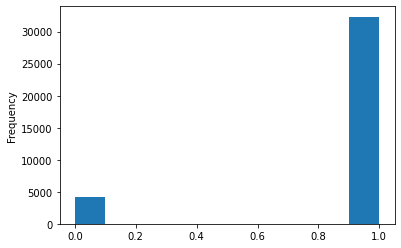

In [4]:
## Label the ID to their corresponding labels 
## Good: 1, Bad: 0 

#Helper functions
def label(row):
    '''
    labels the rows if they are good or bad
    using the above criteria 
    '''
    if row['STATUS'] == 'C' or row['STATUS'] == '0' or row['STATUS'] == 'x':
        return 1
    else:
        return 0 
def filter_groups(group):
    '''
    Removed any of the groups that did not have 0 in their months
    this indicates that while their application data is recent 
    their credit history is not 
    '''
    # return (group['MONTHS_BALANCE'] != 0).any()
    return True
    

def helper(row):
    '''
    Credit csv contains multiple rows with the same ID
    for the same ID some of the labels are good/bad depending on the month
    for each ID we classify them as good or bad by taking the average of the labels
    then setting the threshold to be 1
    '''
    if row['Label'] < 0.20 :  # Hyperparameter to be tuned
        return 0
    return 1 

# Label the ID in credit csv
credit_record['Label'] = credit_record.apply(label, axis = 1 )

# Group the credit data by ID 
grouped_credit = credit_record.groupby('ID')

# Create a new DataFrame containing groups where 'MONTH_BALANCE' doesn't contain 0
filtered_df = grouped_credit .filter(filter_groups)

# Reset the index of the filtered DataFrame
filtered_df = filtered_df.reset_index(drop=True)

#Aggregation for each of the ID to determine if they are good or bad overall
filtered_groupby = filtered_df.groupby('ID')['Label'].mean().reset_index()
filtered_groupby.columns = ['ID', 'Label']
filtered_groupby['Label'] = filtered_groupby.apply(helper, axis = 1)

# Combine the credit data with application data.
df = application_record.merge(filtered_groupby, on='ID', how='left')
df = df.dropna(subset=['Label'])
df['Label'].plot.hist()


# Vintage Analysis for justification of labelling 

Using the code below, we justify why we set the criteria to "if the borrower takes longer than 29 days, he / she will be classified as "bad"" 


In [5]:
#Preparing the data for vintage analysis

#Pivot the df to fit 
credit_pivot = credit_record.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
#Group the data based on the same id -> same person
credit_grouped = credit_record.groupby('ID')
#create new column for the starting month and the ending month 
credit_pivot['open_month'] = credit_grouped['MONTHS_BALANCE'].min()
credit_pivot['end_month'] = credit_grouped['MONTHS_BALANCE'].max()
credit_pivot['ID'] = credit_pivot.index
credit_pivot = credit_pivot[['ID', 'open_month', 'end_month']]
credit_pivot.reset_index(drop=True, inplace=True)
credit_pivot["window_month"] = credit_pivot['end_month']-credit_pivot['open_month']
credit = pd.merge(credit_record, credit_pivot, how = 'left', on = 'ID')
credit['MOB'] = credit['MONTHS_BALANCE'] - credit['open_month']
credit.sort_values(['ID','MOB'], inplace = True)

Text(0.5, 1.0, 'Percentage of "Bad" Customer if we set due date > x axis')

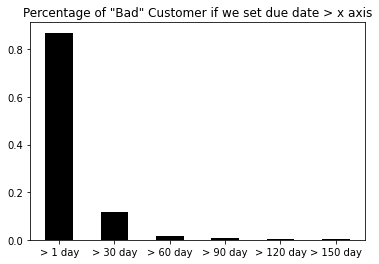

In [6]:
#calculate the percentage of "bad" customer, for all categories 
'''
0: 1-29 days past due 
1: 30-59 days past due 
2: 60-89 days overdue 
3: 90-119 days overdue 
4: 120-149 days overdue 
5: Overdue or bad debts, 
write-offs for more than 150 days 
C: paid off that month 
X: No loan for the month
'''

def calc1(credit_pivot): 
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

def calc30(credit_pivot):
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

def calc60(credit_pivot):
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

def calc90(credit_pivot):
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

def calc120(credit_pivot):
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

def calc150(credit_pivot):
    credit['status'] = None
    credit.loc[(credit['STATUS'] == '5'), 'status'] = 1
    mean = credit.groupby('ID')['status'].sum()
    credit_pivot = pd.merge(credit_pivot, mean, on = 'ID', how = 'left')
    credit_pivot.loc[credit_pivot['status'] > 1, 'status'] = 1
    rate = credit_pivot['status'].sum() / len(credit_pivot)
    return round(rate, 5)

morethan1 = calc1(credit_pivot)
morethan30 = calc30(credit_pivot)
morethan60 = calc60(credit_pivot)
morethan90 = calc90(credit_pivot)
morethan120 = calc120(credit_pivot)
morethan150 = calc150(credit_pivot)

xaxis = ["> 1 day", "> 30 day", "> 60 day", "> 90 day","> 120 day","> 150 day"]
yaxis = [morethan1,morethan30,morethan60,morethan90,morethan120,morethan150]

#create bar graph
plt.bar(xaxis, yaxis, color ='black', 
        width = 0.5)
plt.title('Percentage of "Bad" Customer if we set due date > x axis')

# Vintage analysis result evaluation

From the bar plot, we see that that is a huge drop in the percentage of "bad" customers when we take the threshold to be more than 30 days instead of more than 1 day. Any threshold after 30 due days results in a less significant drop in "bad" customers. Hence, we will classify "bad" customers as borrower who takes longer than 29 days to return their due.

We can also observe that there are some imbalances in the data we continue with the data cleaning below. We want to remove certain columns that are not useful and find the distribution of the remaining column data

In [7]:
# Clean Occupation Type. For individuals who are Pensioner and their occupation is NA, we change it to 'Retired'
df.loc[(df['OCCUPATION_TYPE'].isna()) & (df['NAME_INCOME_TYPE'] == 'Pensioner'), 'OCCUPATION_TYPE'] = 'Retired'

# Columns containing qualitative data
qualitative = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
               'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE']

# Change Qualitative Variables to their dummy indicator.
def encoding_helper(df:pd.DataFrame, columns: list[str]):
    '''
    Loops through the list of qualitative columns, then encodes them
    //I think there is a better way but im lazy to go find it 
    //Our dataset is quite small anyway
    //take note that cache lets us find the mappings later 
    '''
    cache = {}
    for column in columns: 
        mapping = {value : index for index, value in enumerate(df[column].unique())}
        cache[column] = mapping 
        df[column] = df[column].map(mapping)
    
    return df ,cache

df, cache = encoding_helper(df, qualitative)



# Correlation Matrix 

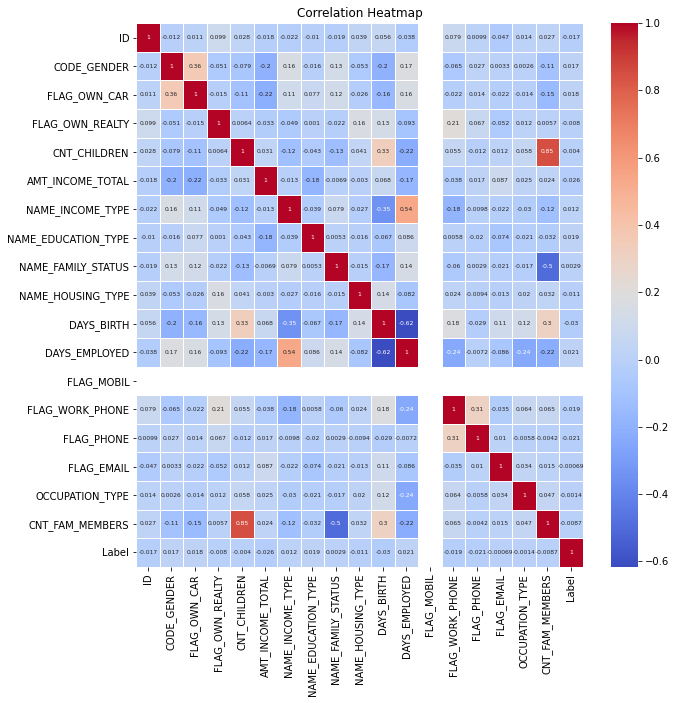

In [8]:
corr_matrix = df.corr()

# Create a heatmap using Seaborn
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
for text in heatmap.texts:
    text.set_fontsize(6) 
plt.title('Correlation Heatmap')
plt.show()

In [9]:
# Dropping the columns that are inconsequential in our code
drop_columns = ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL']
df = df.drop(columns = drop_columns)

# Making Cleaning up the days for DAYS_BIRTH and DAYS_Employed columns 
def days_helper(df:pd.DataFrame, columns :list[int]):
    '''
    Since the age and employed days are in days, we change it to years for better interpretability 
    for the employed column, if the value is negative, it indicated unemployement for x number of days
    '''
    for column in columns:
        df[column] = -df[column]/365
    
    return df 

date_columns = ['DAYS_BIRTH','DAYS_EMPLOYED']

df = days_helper(df, date_columns)


In [10]:
# Renaming of the DataFrame for easier access 
new_names = {'CODE_GENDER' : "gender","FLAG_OWN_CAR":'car','FLAG_OWN_REALTY':'property','CNT_CHILDREN':'number of children','AMT_INCOME_TOTAL': 'income',
             'NAME_INCOME_TYPE': 'income type','NAME_EDUCATION_TYPE':'education','NAME_FAMILY_STATUS':'marital status','NAME_HOUSING_TYPE':'housing type',
             'DAYS_BIRTH':'age','DAYS_EMPLOYED':'years employed','OCCUPATION_TYPE':'occupation','CNT_FAM_MEMBERS':'number of family members','Label':'class'}

df = df.rename(columns = new_names)

In [11]:
df.head()

,ID,gender,car,property,number of children,income,income type,education,marital status,housing type,age,years employed,occupation,number of family members,class
0,5008804,0,0,0,0,427500.0,0,0,0,0,32.890411,12.443836,0,2.0,1.0
1,5008805,0,0,0,0,427500.0,0,0,0,0,32.890411,12.443836,0,2.0,1.0
2,5008806,0,0,0,0,112500.0,0,1,1,1,58.832877,3.106849,1,2.0,1.0
3,5008808,1,1,0,0,270000.0,1,1,2,1,52.356164,8.358904,2,1.0,1.0
4,5008809,1,1,0,0,270000.0,1,1,2,1,52.356164,8.358904,2,1.0,0.0


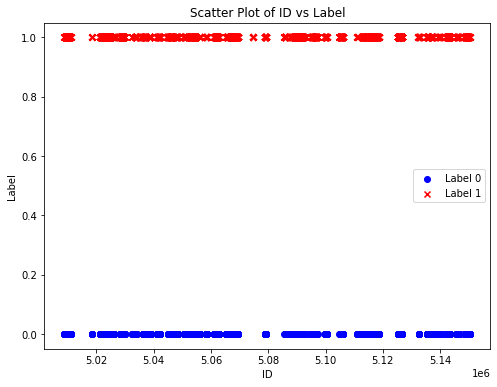

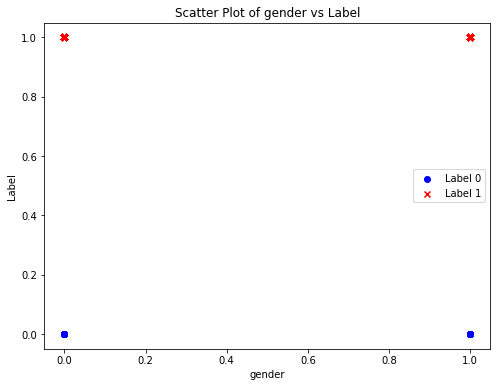

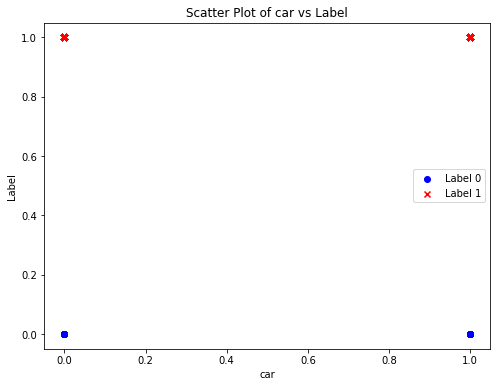

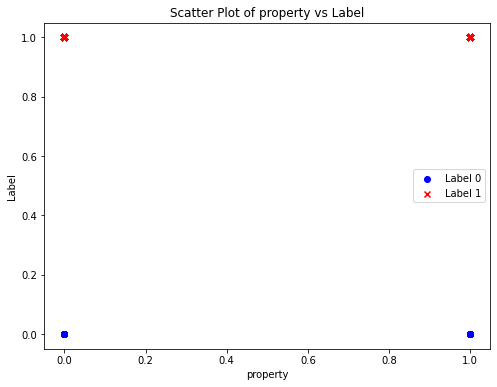

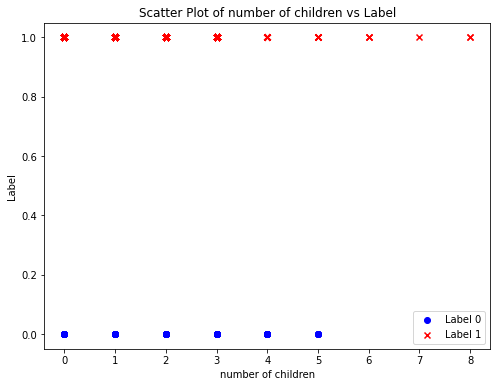

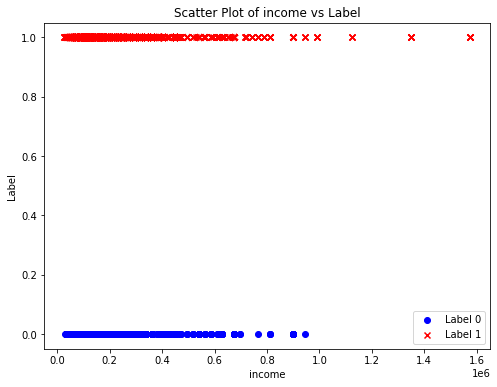

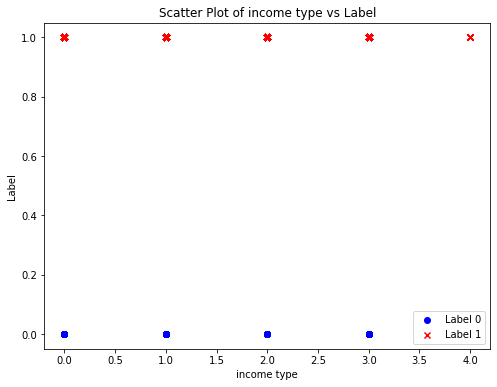

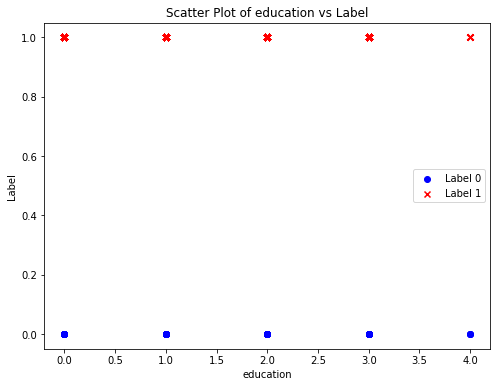

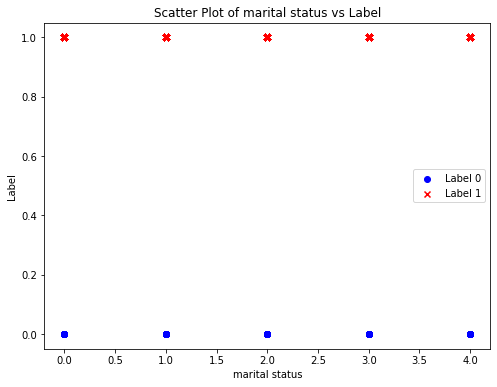

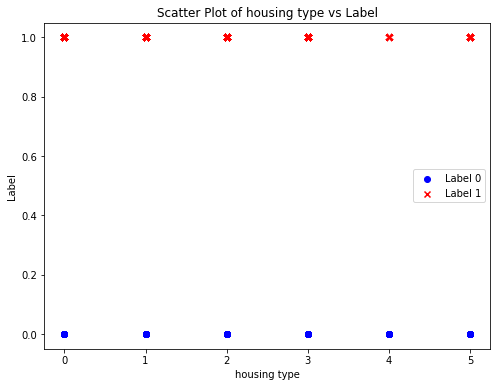

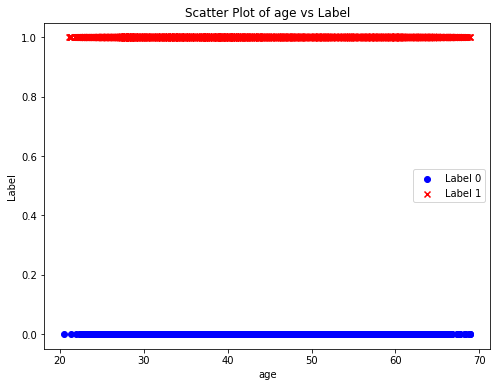

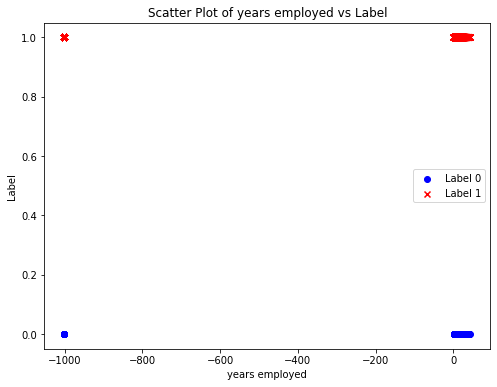

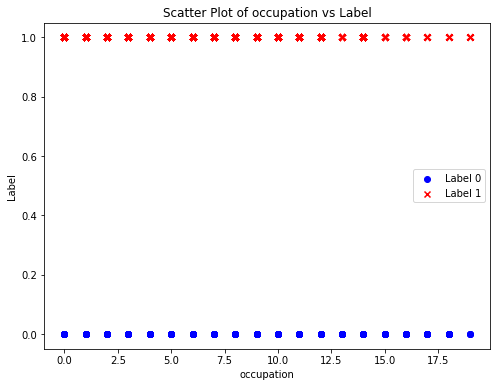

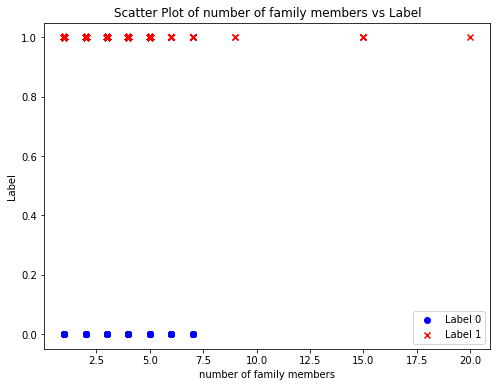

In [12]:
# Plot of the labels vs the individual features 

# Split the DataFrame into two separate DataFrames based on the label values
df_label_0 = df[df['class'] == 0]
df_label_1 = df[df['class'] == 1]

# Create a scatter plot for each feature
for feature in df.columns[:-1]:  # Exclude the 'label' column
    plt.figure(figsize=(8, 6))
    plt.scatter(df_label_0[feature], df_label_0['class'], label='Label 0', color='blue', marker='o')
    plt.scatter(df_label_1[feature], df_label_1['class'], label='Label 1', color='red', marker='x')
    plt.xlabel(feature)
    plt.ylabel('Label')
    plt.title(f'Scatter Plot of {feature} vs Label')
    plt.legend()
    plt.show()

# Failure of scatterplots

We can observe that scatter plots do not work well for our dataset. This can be explained by the following reasons

1. Most of our variables are qualitative variables and we encode them with numerical variables. Since the variables are not quantitative and continuous, we are not able to produce a good scatterplot of the data that we have on hand. 

2. There are only 2 binary classes, which will only be represented by two points. 

Given this, we are going to attempt to do feature selection without the use of scatter plots to evaluate our model. 

# Data splitting 

In [13]:
#Without SMOTE
from sklearn.model_selection import train_test_split

X_base = df[['gender', 'car', 'property', 'number of children', 'income',
       'income type', 'education', 'marital status', 'housing type', 'age',
       'years employed', 'occupation', 'number of family members']]
y_base = df['class']

# Split the data into training and testing sets
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size = 0.20, random_state = 42)

## Improvement 1: SMOTE

In [14]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the Data from the DataFrame
X = df[['gender', 'car', 'property', 'number of children', 'income',
       'income type', 'education', 'marital status', 'housing type', 'age',
       'years employed', 'occupation', 'number of family members']]
y = df['class']

# Adjust for oversampling 

from imblearn.over_sampling import RandomOverSampler, SMOTE 

def balancing(X,y,type):
       '''
       This function helps us to choose the type of resampling that we 
       want to do, functional abstraction, 1010 things :-)
       '''
       ros = RandomOverSampler(random_state=42)
       smote = SMOTE(random_state=42)
       if type == 'oversample':
              return ros.fit_resample(X, y)
       else:
              return smote.fit_resample(X,y)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# Balance the training data 
X_train , y_train = balancing(X_train , y_train, 'smote')



In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold  


def cross_validate(model , X , y):
    num_folds = 5
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    # Perform cross-validation and get the accuracy scores for each fold
    cross_val_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    # Print the accuracy scores for each fold
    print("Cross-validation scores:", cross_val_scores)

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

Training Accuracy: 0.95
Cross-validation scores: [0.90870447 0.91556371 0.91305188 0.910057   0.91178744]
Accuracy: 0.85957213384531
              precision    recall  f1-score   support

         0.0       0.40      0.45      0.42       844
         1.0       0.93      0.91      0.92      6448

    accuracy                           0.86      7292
   macro avg       0.67      0.68      0.67      7292
weighted avg       0.87      0.86      0.86      7292



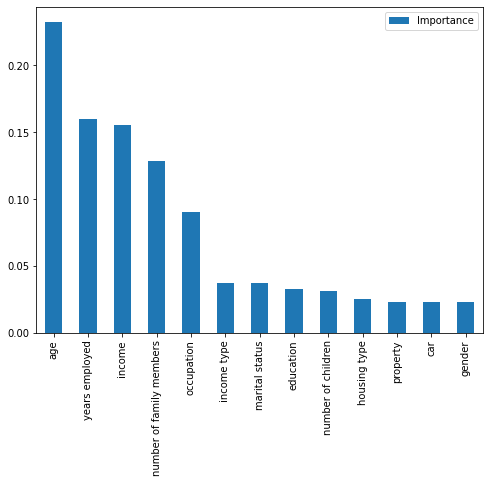

In [17]:
# Fit the RF model

def randomforest(X_train , y_train , X_test, y_test):
    """
    Abstracted function for using a random forest classifer
    Inputs: X,y for test and train 
    Output: Prints accuracy and importance plots 
    Returns: N/A
    """
    clf = RandomForestClassifier(n_estimators=100, bootstrap= True)

    # Fit the model on the training data
    clf.fit(X_train, y_train)

    # Predict labels on training data 
    y_train_pred = clf.predict(X_train)

    # Accuracy of the training data 
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training Accuracy: {training_accuracy:.2f}')

    # Cross Validation Score
    cross_validate(clf, X_train , y_train)
    
    # Predict labels on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')

    # Print a classification report
    report = classification_report(y_test, y_pred)
    print(report)

    # Importance plot 

    feat_importances = pd.DataFrame(clf.feature_importances_, index= X_train.columns, columns=["Importance"])
    feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
    feat_importances.plot(kind='bar', figsize=(8,6))


randomforest(X_train, y_train, X_test, y_test)

## Random Forest Baseline Model without SMOTE

Training Accuracy: 0.93
Cross-validation scores: [0.89833705 0.8887365  0.89439397 0.88719355 0.89113664]
Accuracy: 0.8908392759188152
              precision    recall  f1-score   support

         0.0       0.55      0.33      0.41       844
         1.0       0.92      0.96      0.94      6448

    accuracy                           0.89      7292
   macro avg       0.73      0.65      0.67      7292
weighted avg       0.87      0.89      0.88      7292



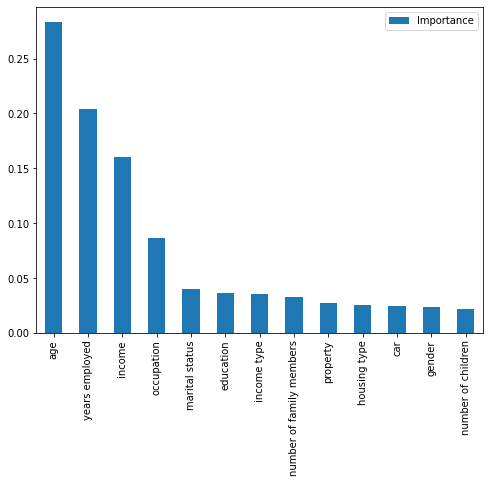

In [18]:
randomforest(X_train_base, y_train_base, X_test_base, y_test_base)

# Improvement 2: XGBoost Tree
We observed high testing accuracy of 83.65% using basic random forest model. We wish to see if more improvements could be made to increase the accuracy more.

In [19]:
import xgboost as xgb

Training Accuracy: 0.89
Cross-validation scores: [0.85827456 0.86561685 0.86552024 0.8565356  0.86144928]
Accuracy: 0.8398244651673067
              precision    recall  f1-score   support

         0.0       0.33      0.38      0.36       844
         1.0       0.92      0.90      0.91      6448

    accuracy                           0.84      7292
   macro avg       0.63      0.64      0.63      7292
weighted avg       0.85      0.84      0.84      7292



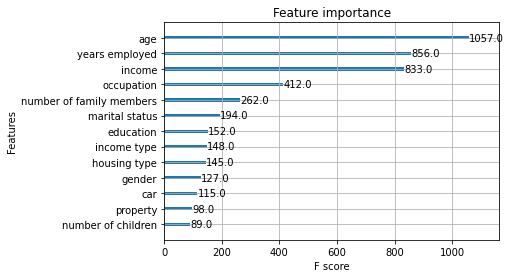

In [20]:
# Gradient boosted tree with xgboost


def xgbmodel(X_train , y_train , X_test, y_test):
    """
    Abstracted function for using gradient boosting
    Inputs: X,y for test and train 
    Output: Prints accuracy and importance plots 
    Returns: N/A
    """
    # specify parameters via map
    xgb_model = xgb.XGBClassifier()

    # Fit the model 
    xgb_model.fit(X_train,y_train)

    # Predict labels on training data 
    y_train_pred = xgb_model.predict(X_train)

    # Accuracy of the training data 
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training Accuracy: {training_accuracy:.2f}')

    # Cross Validation Score
    cross_validate(xgb_model, X_train , y_train)

    # Make Prediction 
    y_pred = xgb_model.predict(X_test)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy}')
    
    # Print a classification report
    report = classification_report(y_test, y_pred)
    print(report)

    xgb.plot_importance(xgb_model)


xgbmodel(X_train , y_train, X_test, y_test)

# Evaluation of result using gradient boosting

As we see from above, the accuracy of using a random forest model with gradient boosting did not help improve our accuracy. This could be caused by the following reason
Gradient boosting tends to fit data closely and is prone to overfitting if not properly tuned. It is possible that our hyperparameters for gradient boosting are not optimized which led to overfitting.

# Improvement 3: Naive Feature Selection

From the above importance plot, we can observe that Years employed, income, and age are the most important factors when constructing the decision tree. 

In both of the models, we have seen that we used all the features in order to create the decision tree, now, we test  with the top 5 most important features to see if there is any improvement in the performance 

Theoretically, we hope to decrease the model variances from the usages of too many features, but we are aware that this also increases the model bias as we are manually choosing the features based on the importance plot

# Random Forest with naive feature selection

Training Accuracy: 0.95
Cross-validation scores: [0.86893485 0.86951479 0.86912817 0.87230546 0.87462542]
Accuracy: 0.848052660449808
              precision    recall  f1-score   support

         0.0       0.37      0.47      0.41       831
         1.0       0.93      0.90      0.91      6461

    accuracy                           0.85      7292
   macro avg       0.65      0.68      0.66      7292
weighted avg       0.87      0.85      0.86      7292



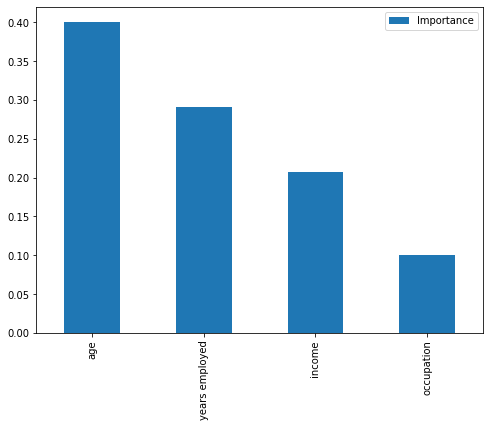

In [22]:
# Choosing the subset based on our above observations
subset = ['age', 'years employed','income', 'occupation']

# Define the subset
X_subset = df[subset]

# Train test split for the subset
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X_subset, y, test_size = 0.2)

# Balancing for trainset 
X_train_subset, y_train_subset = balancing(X_train_subset, y_train_subset, 'smote')

randomforest(X_train_subset, y_train_subset, X_test_subset, y_test_subset)


# Logistic Regression 

In [23]:
from sklearn.linear_model import LogisticRegression

## Logistic Regression with SMOTE

In [24]:
# Create a logistic regression model

def logisticmodel(X_train, y_train, X_test, y_test):
    logistic = LogisticRegression()

    # Fit the model on the training data
    logistic.fit(X_train, y_train)

    # Predict labels on training data 
    y_train_pred = logistic.predict(X_train)

    # Accuracy of the training data 
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training Accuracy: {training_accuracy:.2f}')

    # Cross Validation Score
    cross_validate(logistic, X_train , y_train)

    # Predict labels on the test data
    y_pred = logistic.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Print a classification report
    report = classification_report(y_test, y_pred)
    print(report)

logisticmodel(X_train, y_train, X_test, y_test)

Training Accuracy: 0.52
Cross-validation scores: [0.52062603 0.52951406 0.52284803 0.51009564 0.50434783]
Accuracy: 0.56
              precision    recall  f1-score   support

         0.0       0.13      0.47      0.20       844
         1.0       0.89      0.58      0.70      6448

    accuracy                           0.56      7292
   macro avg       0.51      0.52      0.45      7292
weighted avg       0.80      0.56      0.64      7292



## Logistic Regression Baseline Model without SMOTE

In [25]:
logisticmodel(X_train_base, y_train_base, X_test_base, y_test_base)

Training Accuracy: 0.89
Cross-validation scores: [0.89473684 0.88085033 0.89285102 0.88462198 0.88325047]
Accuracy: 0.88
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       844
         1.0       0.88      1.00      0.94      6448

    accuracy                           0.88      7292
   macro avg       0.44      0.50      0.47      7292
weighted avg       0.78      0.88      0.83      7292



## Logistic Regression with naive feature selection

In [26]:
# Fit logistic on selected features
logisticmodel(X_train_subset,y_train_subset,X_test_subset,y_test_subset)

Training Accuracy: 0.51
Cross-validation scores: [0.51188865 0.50705587 0.52165088 0.50961817 0.50343161]
Accuracy: 0.25
              precision    recall  f1-score   support

         0.0       0.12      0.86      0.21       831
         1.0       0.90      0.17      0.29      6461

    accuracy                           0.25      7292
   macro avg       0.51      0.51      0.25      7292
weighted avg       0.81      0.25      0.28      7292



# Evaluating the models 

In the above we have established the models of comparison, we can summarise the results as follows: 
1. `Random Forest Baseline`: 0.8908392759188152
2. `Random Forest with SMOTE`: 0.85957213384531
3. `XGBoosted Tree`: 0.8297146401985112
4. `Random Forest with naive feature selection`: 0.848052660449808
5. `Logistic Regression Baseline` : 0.88
6. `Logistic Regression with SMOTE` : 0.56
7. `Logistic Regression with naive feature selection`: 0.25


We can observe that the naive feature selection method that we used decreased the accuracy in the Random Forest. It can happen for the following reasons 

* Random Forests are able to average the errors made by using different predictors in different trees, by decreasing the number of features that we input into the building of the tree, we are essentially not allowing the model to make different errors at test time, making the model have a higher variance. 

* Since Random Forests are able to make complex non-linear decision boundaries, additional features may help to increase the depth of the tree. By limiting the number of features, we limit the ability of the Random Forest to form more meaningful and complex boundaries. 

From our result, we can hypothesize that the 'improved' Random Forest model with naive feature selection is suffering from high bias. 


Also, both the logistics regression models seem to have terrible performance. This can be attributed to: 

* The boundaries are very non-linear, a linear model is not able to capture a good boundary in the data 



For further improvement, we experiment with new ways of feature extraction and engineering

Feature Analysis (changing feature values giving different graphs)

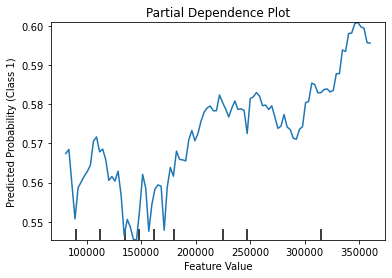

In [ ]:
from sklearn.inspection import plot_partial_dependence

# Example: RandomForestClassifier
plot_partial_dependence(clf, X_train, features=[4], grid_resolution=100)
plt.xlabel('Feature Value')
plt.ylabel('Predicted Probability (Class 1)')
plt.title('Partial Dependence Plot')
plt.show()

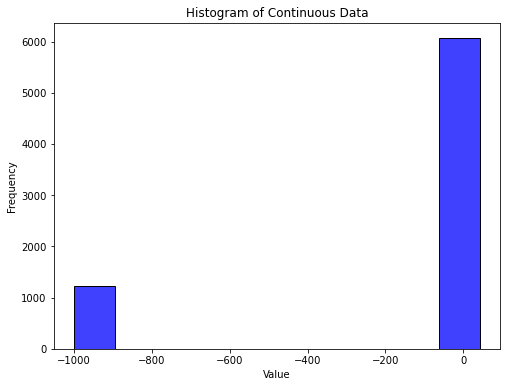

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(X_test["years employed"], bins=10, kde=False, color='blue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Continuous Data')
plt.show()

# Feature selection using L1 Penalty (LASSO)

In [23]:
def PenalisedClassification(X_train, y_train, X_test, y_test):
    logistic = LogisticRegression(penalty = 'l1', solver= 'saga')

    # Fit the model on the training data
    logistic.fit(X_train, y_train)

    # Predict labels on training data 
    y_train_pred = logistic.predict(X_train)

    # Accuracy of the training data 
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training Accuracy: {training_accuracy:.2f}')

    # Cross Validation Score
    cross_validate(logistic, X_train , y_train)

    # Predict labels on the test data
    y_pred = logistic.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Print a classification report
    report = classification_report(y_test, y_pred)
    print(report)

In [24]:
PenalisedClassification(X_train , y_train , X_test, y_test)

# Not in use

Training Accuracy: 0.51
Cross-validation scores: [0.51579558 0.50893633 0.52014298 0.50584485 0.50318841]
Accuracy: 0.51
              precision    recall  f1-score   support

         0.0       0.51      0.91      0.65      6448
         1.0       0.55      0.12      0.19      6448

    accuracy                           0.51     12896
   macro avg       0.53      0.51      0.42     12896
weighted avg       0.53      0.51      0.42     12896



# Combine the XGBoost and Random Forest

We create an emsemble method that uses XGBoost and Random Forests 

Training Accuracy: 0.69
Cross-validation scores: [0.68080379 0.68689016 0.69027147 0.67974109 0.68898551]
Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73      6448
         1.0       0.73      0.73      0.73      6448

    accuracy                           0.73     12896
   macro avg       0.73      0.73      0.73     12896
weighted avg       0.73      0.73      0.73     12896



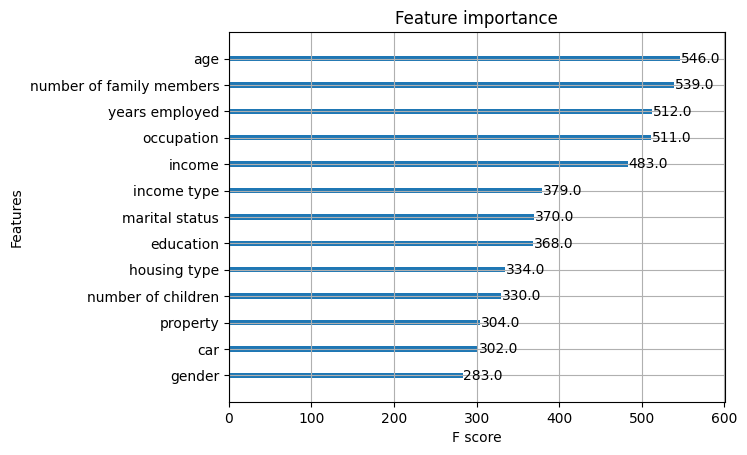

In [25]:
from xgboost import XGBRFClassifier

def xgboostedrf(X_train ,y_train , X_test, y_test):

    # Load the models
    model = XGBRFClassifier()

    model = XGBRFClassifier(n_estimators=100, subsample=0.9, colsample_bynode=0.2)

    model.fit(X_train , y_train)

    # Predict labels on training data 
    y_train_pred = model.predict(X_train)

    # Accuracy of the training data 
    training_accuracy = accuracy_score(y_train, y_train_pred)
    print(f'Training Accuracy: {training_accuracy:.2f}')

    # Cross Validation Score
    cross_validate(model, X_train , y_train)

    # Predict labels on the test data
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Print a classification report
    report = classification_report(y_test, y_pred)
    print(report)

    xgb.plot_importance(model)
    

xgboostedrf(X_train, y_train , X_test, y_test)

# Multilayer Perceptron 

From our previous experiements, it seems that a non linear boundary is able to fit the data far better than linear models. There was a limit to the seperation offered by linear models. This motivates us to try the most powerful non linear classifier 

In [2]:
#!pip install torch
import torch 
from torch import nn 
from torch.utils.data import Dataset, DataLoader, TensorDataset


In [ ]:
# Convert our datatypes to PyTorch Tensors 
X_train_tensor = torch.tensor(X_train.values).type(torch.float32)
y_train_tensor = torch.tensor(y_train.values).type(torch.float32)
X_test_tensor = torch.tensor(X_test.values).type(torch.float32)
y_test_tensor = torch.tensor(y_test.values).type(torch.float32)

# Create PyTorch Dataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define batch size
batch_size = 256

# Create DataLoader objects for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Initialised for later 
INPUT_SIZE  = X_train_tensor.shape[1]

In [ ]:
# Build the MLP

class MLPClassifier(nn.Module):
    def __init__(self, input_features, hidden_units):
        super().__init__()
        self.layer_stacks = nn.Sequential(
            nn.Linear(in_features=input_features, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features= 1)
        )

    def forward(self, x):
        return self.layer_stacks(x)
    
MLP = MLPClassifier(INPUT_SIZE, 256)

In [ ]:
# Loss function 
loss_fn = nn.BCEWithLogitsLoss()
# Optimiser 
optimizer = torch.optim.SGD(params = MLP.parameters(), lr = 1e-2)
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc


# Training and Evaluation Loop

epochs = 100

for epoch in range(epochs):
    MLP.train()
    for batch_X, batch_y in train_loader:
      # Zero grad 
      optimizer.zero_grad()

      # Forward pass 
      y_logits = MLP(batch_X).squeeze()
      y_pred = torch.round(torch.sigmoid(y_logits))

      # Loss calculation 
      loss = loss_fn(y_logits, batch_y)

      acc = accuracy_fn(y_pred, batch_y)

      # Backpropagate
      loss.backward()

      # Update Params
      optimizer.step()

    # Evaluation 
    MLP.eval()
    with torch.inference_mode():
       test_logits = MLP(X_test_tensor).squeeze()
       test_pred = torch.round(torch.sigmoid(test_logits))

       # Test Loss
       test_loss = loss_fn(test_logits, y_test_tensor)
       test_accuracy = accuracy_fn(y_test_tensor, test_pred)

    if epoch % 10 == 0 : 
       print(f'Epoch: {epoch} | Training Loss: {loss} | Training Accuracy : {acc} | Test Loss : {test_loss} | Test Accuracy: {test_accuracy}')


Epoch: 0 | Training Loss: 0.693169116973877 | Training Accuracy : 47.61904761904761 | Test Loss : 0.6931472420692444 | Test Accuracy: 50.0
Epoch: 10 | Training Loss: 0.6931623220443726 | Training Accuracy : 45.23809523809524 | Test Loss : 0.6931471824645996 | Test Accuracy: 50.0
Epoch: 20 | Training Loss: 0.6932734847068787 | Training Accuracy : 42.857142857142854 | Test Loss : 0.6931471824645996 | Test Accuracy: 50.0
Epoch: 30 | Training Loss: 0.6931361556053162 | Training Accuracy : 52.38095238095239 | Test Loss : 0.6931473612785339 | Test Accuracy: 50.0
Epoch: 40 | Training Loss: 0.6932112574577332 | Training Accuracy : 47.61904761904761 | Test Loss : 0.6931477189064026 | Test Accuracy: 50.0
Epoch: 50 | Training Loss: 0.6931472420692444 | Training Accuracy : 50.0 | Test Loss : 0.6931471824645996 | Test Accuracy: 50.0
Epoch: 60 | Training Loss: 0.6932000517845154 | Training Accuracy : 33.33333333333333 | Test Loss : 0.6931481957435608 | Test Accuracy: 50.0
Epoch: 70 | Training Loss: 

# MLP Results 

The results are not good. There is no learning happening between epochs

The dataset primarily comprises tabular data, contributing to a loss function that exhibits a predominantly flat behavior, consequently impeding substantial learning. Furthermore, we have sought validation from the teaching assistants regarding the correctness of the code, and it has been verified as accurate.